## Problem Statement

Quora is a platform that empowers people to learn from each other. On Quora, people can ask questions and connect with others who contribute unique insights and quality answers. A key challenge is to weed out insincere questions -- those founded upon false premises, or that intend to make a statement rather than look for helpful answers.

## Aim 

It is binary classification problem. We have to predict whether a question asked on Quora is sincere or not.

## Data Description


    train.csv - the training set
    test.csv - the test set
    sample_submission.csv - A sample submission in the correct format
    enbeddings/ - (see below)

### Attributes


    qid - unique question identifier
    question_text - Quora question text
    target - a question labeled "insincere" has a value of 1, otherwise 0

### Evalution

     F1 Score between the predicted and the observed targets.


In [1]:
!pip install contractions

     |████████████████████████████████| 312 kB 6.1 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp37-cp37m-linux_x86_64.whl size=99053 sha256=176fd4b57d3dc1cd8b9773c4a46197217fff3df3e5ff7d30bb99217d2760503e
  Stored in directory: /root/.cache/pip/wheels/9b/6b/f7/62dc8caf183b125107209c014e78c340a0b4b7b392c23c2db4
Successfully built pyahocorasick


In [2]:
#importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn
import re
import warnings
import string
from nltk.corpus import stopwords
import contractions
from nltk.stem import PorterStemmer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.metrics import f1_score,accuracy_score
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from wordcloud import WordCloud,STOPWORDS
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from scipy.sparse import hstack
from sklearn.preprocessing import normalize


stopwords_word=set(STOPWORDS)
ps=PorterStemmer()
pun=string.punctuation
stop_words=stopwords.words("english")
warnings.filterwarnings("ignore")

## Data Overview

In [3]:
train_df=pd.read_csv("../input/quora-insincere-questions-classification/train.csv")
test_df=pd.read_csv("../input/quora-insincere-questions-classification/test.csv")

In [4]:
print("Training Dataset")
display(train_df.head())
print("")
print("Testing Dataset")
display(test_df.head())


Training Dataset


,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0



Testing Dataset


,qid,question_text
0,0000163e3ea7c7a74cd7,Why do so many women become so rude and arroga...
1,00002bd4fb5d505b9161,When should I apply for RV college of engineer...
2,00007756b4a147d2b0b3,What is it really like to be a nurse practitio...
3,000086e4b7e1c7146103,Who are entrepreneurs?
4,0000c4c3fbe8785a3090,Is education really making good people nowadays?


In [5]:
print("Number of Question in Training dataset :",train_df.shape[0])
print("Number of Question in Testinig dataset :",test_df.shape[0])

Number of Question in Training dataset : 1306122
Number of Question in Testinig dataset : 375806


### Missing values and Duplicates values

In [6]:
print("Total Missing values in the Dataset :",train_df.isnull().sum().sum())
print("Total Missing values in the Dataset :",train_df.duplicated().sum())

Total Missing values in the Dataset : 0
Total Missing values in the Dataset : 0


## Exploratory Data Analysis

#### Analysis of the Target Variable

In [7]:
train_df.target.value_counts()

0    1225312
1      80810
Name: target, dtype: int64

Text(0.0, 1.0, 'Distribution of Target')

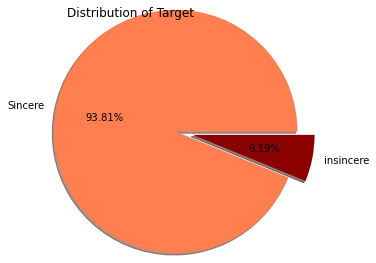

In [8]:
## visulaizing the target variable by plotting the pie diagrams
plt.pie(train_df.target.value_counts(),autopct=lambda x:str(round(x,2))+"%",explode=(0,0.2),
        labels=["Sincere","insincere"],radius=1.4,colors=["coral","darkred"],shadow=True,center=(0,3))
plt.title("Distribution of Target",loc='left')

- It was an High imbalanced data with the majority class is 93.8%

### Analysis of Text

In [9]:
sincere_text=" ".join(train_df.loc[train_df.target==0]['question_text'])
insincere_text=" ".join(train_df.loc[train_df.target==1]['question_text'])

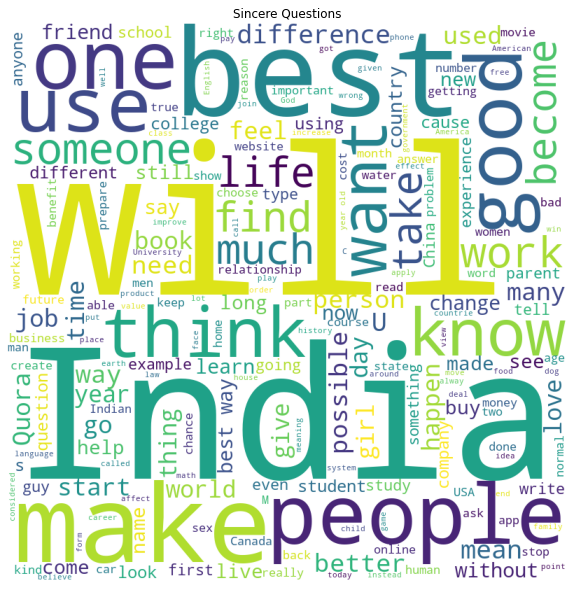

CPU times: user 56.7 s, sys: 1.25 s, total: 58 s
Wall time: 58 s


In [10]:
%%time
## Generating Word cloud
wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwords_word, 
            min_font_size = 10).generate(sincere_text) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.title("Sincere Questions")
plt.tight_layout(pad = 0) 

plt.show() 

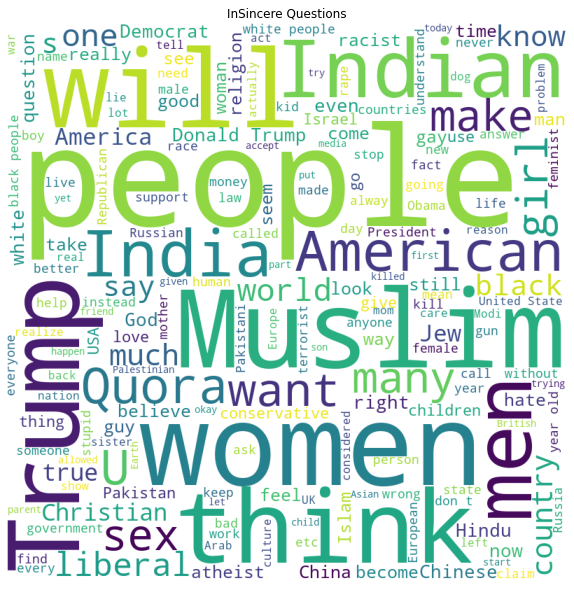

CPU times: user 10.2 s, sys: 119 ms, total: 10.3 s
Wall time: 10.3 s


In [11]:
%%time
## Generating Word cloud
wordcloud = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            stopwords = stopwords_word, 
            min_font_size = 10).generate(insincere_text) 

# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.title("InSincere Questions")
plt.tight_layout(pad = 0) 

plt.show() 

### Creating Some Meta Features

**Meta Features before Preprocessing**
- length of the each document
- number of words in a document
- number of punctuations
- number of stopwords.

**Meta Features after Preprocessing**
- lenght of each document
- number of words in a document

In [12]:
# Feature engineering before preprocessing
def Feature_engineering_before_preprocess(corpus):
    # lenth of the each documnet.
    l=[]
    w=[]
    p=[]
    s=[]
    temp=pd.DataFrame()
    for text in corpus:
        l.append(len(text)) # length of the each document
        w.append(len(text.split())) # lenght of the each document 
        p.append(len(re.findall(r"[^a-zA-Z0-9 ]",text)))
        s.append(len([words for words in text.split() if words in stop_words]))
    temp["length"]=l
    temp["num_words"]=w
    temp["num_punc"]=p
    temp["num_stopwords"]=s
    
    return temp

### feature Engineering after Preprocessing
def Feature_engineering_after_preprocess(corpus):
    # lenth of the each documnet.
    l=[]
    w=[]
    temp=pd.DataFrame()
    for text in corpus:
        l.append(len(text)) # length of the each document
        w.append(len(text.split())) # lenght of the each document 
        
    temp["length_after"]=l
    temp["num_words_after"]=w
    
    return temp

In [13]:
%%time
df_feat=Feature_engineering_before_preprocess(train_df.question_text)

CPU times: user 50.1 s, sys: 52.5 ms, total: 50.1 s
Wall time: 50.2 s


### Preprocessing 

- Removing the weird space
- Remove tokenization
- Contraction mapping
- Removing punctuations and numeric
- Removing stopwords
- stemming

In [14]:
# contraction mapping


def Preprocessing(corpus):
    cor=[]
    for text in corpus:
        text=text.lower()
        text=text.strip()
        text=" ".join([contractions.fix(word) for word in text.split()])
        text=re.sub(r"[^a-zA-Z]"," ",text)
        word=[i for i in text.split() if(len(i)>1 and i.isalpha() and (i not in stop_words))]
        text=" ".join(ps.stem(i) for i in word)
        cor.append(text)
    return cor

In [15]:
%%time
# preprocessing the Text
clean_text=Preprocessing(train_df.question_text)

CPU times: user 7min 14s, sys: 524 ms, total: 7min 14s
Wall time: 7min 14s


In [16]:
%%time
df_feat_after_preprocess=Feature_engineering_after_preprocess(clean_text)

CPU times: user 2.21 s, sys: 48 ms, total: 2.26 s
Wall time: 2.26 s


### Preparing the Dataset

In [17]:
clean_df=pd.DataFrame()
clean_df["qid"]=train_df.qid
clean_df["text"]=clean_text
clean_df=pd.concat([clean_df,df_feat,df_feat_after_preprocess],axis=1)
clean_df["target"]=train_df.target


In [18]:
display(clean_df.head())
## saving this dataframe in to hard disk
clean_df.to_csv("clean_dataset.csv",index=False)

,qid,text,length,num_words,num_punc,num_stopwords,length_after,num_words_after,target
0,00002165364db923c7e6,quebec nationalist see provinc nation,72,13,1,6,37,5,0
1,000032939017120e6e44,adopt dog would encourag peopl adopt shop,81,16,2,8,41,7,0
2,0000412ca6e4628ce2cf,veloc affect time veloc affect space geometri,67,10,2,1,45,7,0
3,000042bf85aa498cd78e,otto von guerick use magdeburg hemispher,57,9,1,2,40,6,0
4,0000455dfa3e01eae3af,convert montra helicon mountain bike chang tyre,77,15,1,5,47,7,0


#### Loading the cleaned Dataset

In [19]:
#clean_df=pd.read_csv("../input/cleaned-data-quora/clean_dataset.csv")

In [20]:
clean_df.drop(columns="qid",inplace=True)
clean_df.dropna(axis=0,inplace=True)

### Analysis of clean Text

In [21]:
vectorizer=CountVectorizer(max_features=10000,ngram_range=(1,1))

#### Analysis of sincere question of cleaned Text

In [22]:
%%time
vectorizer.fit(clean_df.loc[clean_df.target==0]['text'])
train_feat=vectorizer.transform(clean_df.loc[clean_df.target==0]['text'])


CPU times: user 28.7 s, sys: 379 ms, total: 29.1 s
Wall time: 29.1 s


In [23]:
### Getting the most frequent words whihc relates to the sincere question
count=train_feat.sum(axis=0)
temp=pd.DataFrame()
temp["vocab"]=vectorizer.get_feature_names()
temp["count"]=count.T

In [24]:
temp.sort_values(by='count',ascending=False,inplace=True)

In [25]:
## top 30 most Frequent words in the sincere questions is 
temp.head(10)

,vocab,count
3619,get,69744
873,best,61825
9905,would,59129
5127,like,47730
9439,use,47686
6569,peopl,43729
3685,good,37598
5335,make,35465
6242,one,34305
4356,india,29528


Text(0.5, 1.0, 'Top 50 Most Frequent Words in sincere Question from cleaned data')

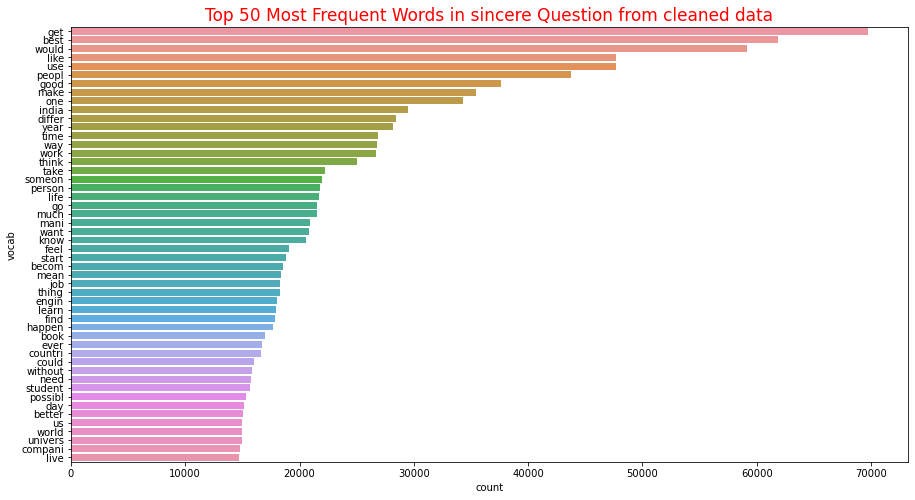

In [26]:
## plotting most frequent words in the sincere questions
plt.figure(figsize=(15,8))
sbn.barplot(y=temp.vocab[:50],x=temp["count"][:50])
plt.title("Top 50 Most Frequent Words in sincere Question from cleaned data",size=17,color="red")

#### Analysis of Insincere question from clean data

In [27]:
%%time
vectorizer.fit(clean_df.loc[clean_df.target==1]['text'])
train_feat=vectorizer.transform(clean_df.loc[clean_df.target==1]['text'])


CPU times: user 2.23 s, sys: 7.98 ms, total: 2.24 s
Wall time: 2.25 s


In [28]:
count=train_feat.sum(axis=0)
temp=pd.DataFrame()
temp["vocab"]=vectorizer.get_feature_names()
temp["count"]=count.T

In [29]:
temp.sort_values(by='count',ascending=False,inplace=True)
## top 10 most Frequent words in the sincere questions is 
temp.head(10)

,vocab,count
6552,peopl,13054
9124,trump,6669
5190,like,6451
9857,women,6039
4377,indian,5703
5879,muslim,5625
318,american,4941
9885,would,4494
9772,white,4324
8903,think,4280


Text(0.5, 1.0, 'Top 50 Most Frequent Words  Insincere Question from cleaned data')

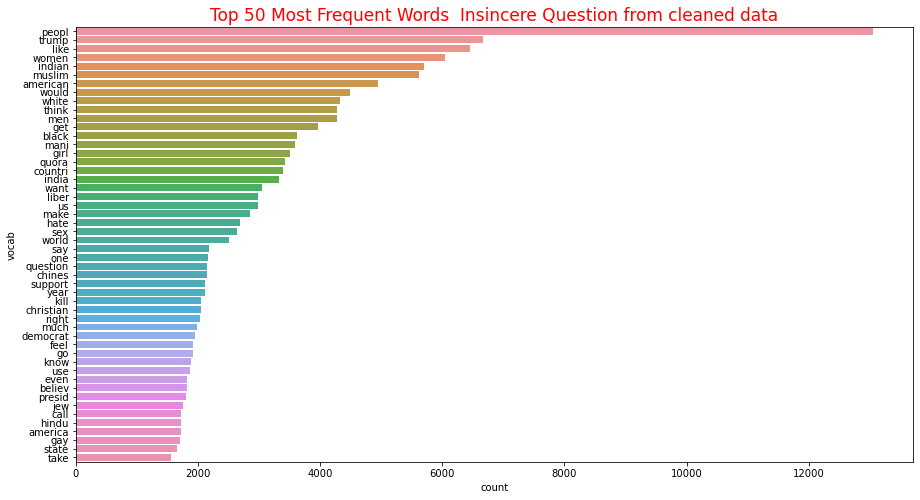

In [30]:
## plotting most frequent words in the sincere questions
plt.figure(figsize=(15,8))
sbn.barplot(y=temp.vocab[:50],x=temp["count"][:50])
plt.title("Top 50 Most Frequent Words  Insincere Question from cleaned data",size=17,color="red")

### Experiment 1: Base Modelling (with the basic derived meta features)

- model : Random Forrest

In [31]:
## getting the basic statistics for the basic features
round(clean_df.iloc[:,2:].describe(),2)

,num_words,num_punc,num_stopwords,length_after,num_words_after,target
count,1306122.00,1306122.00,1306122.00,1306122.00,1306122.00,1306122.00
mean,12.80,1.78,4.88,38.76,6.34,0.06
std,7.05,1.78,3.45,22.52,3.59,0.24
min,1.00,0.00,0.00,0.00,0.00,0.00
25%,8.00,1.00,3.00,23.00,4.00,0.00
50%,11.00,1.00,4.00,33.00,5.00,0.00
75%,15.00,2.00,6.00,48.00,8.00,0.00
max,134.00,411.00,55.00,451.00,87.00,1.00


In [32]:
temp=clean_df.iloc[:,2:]

CPU times: user 2min 41s, sys: 342 ms, total: 2min 41s
Wall time: 2min 41s


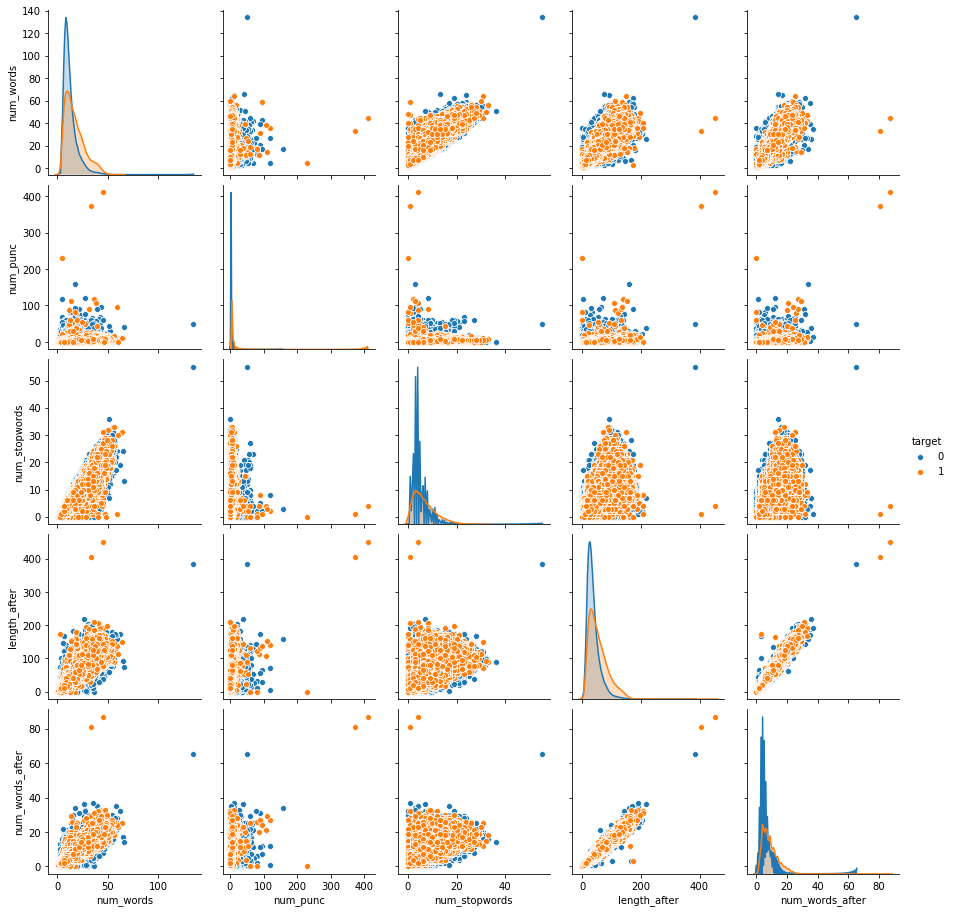

In [33]:
%%time
## visualizing the plots of all distribution
sbn.pairplot(data=temp,hue="target")

In [34]:
## Spliiting in to train and test datasets
x_train,x_val,y_train,y_val=train_test_split(temp.iloc[:,:-1],temp.iloc[:,-1],stratify=temp.iloc[:,-1])

In [35]:
print("Shape of Training Dataset :",x_train.shape,y_train.shape)
print("Shape of Test dataset :",x_val.shape,y_val.shape)

Shape of Training Dataset : (979591, 5) (979591,)
Shape of Test dataset : (326531, 5) (326531,)


In [36]:
## Building the MOdel
model_rf=DecisionTreeClassifier(min_samples_split=5,max_depth=100)
model_rf.fit(x_train,y_train)
y_val_pre=model_rf.predict(x_val)
y_train_pre=model_rf.predict(x_train)

print("Accuracy")
print("train: ",accuracy_score(y_train,y_train_pre))
print("val :",accuracy_score(y_val,y_val_pre))
print("-"*50)
print("F1 score")
print("train: ",f1_score(y_train,y_train_pre))
print("val :",f1_score(y_val,y_val_pre))

Accuracy
train:  0.9463459750038536
val : 0.930132207968003
--------------------------------------------------
F1 score
train:  0.26766431188953443
val : 0.08325966406815076


**It has high bias and high varience so accuracy is very low with this meta features**

## Experiment : 2 TFIDF vectorizer
- Vectorization-> Tfidf vectorizer
- MultinomialNB
- I will not use the any tree based algorithms because it will be a very high dimensional data

In [37]:
x=clean_df.iloc[:,:-1]
y=clean_df.iloc[:,-1]

In [38]:
### Splitting the dataset in to train set and test set 
x_train,x_val,y_train,y_val=train_test_split(x,y,stratify=y,test_size=0.2)
print("shape of the training set :",x_train.shape,y_train.shape)
print("Shape of Testing set :",x_val.shape,y_val.shape)

shape of the training set : (1044897, 7) (1044897,)
Shape of Testing set : (261225, 7) (261225,)


### Feature Extraction with Tfidf vectorizer

In [39]:
## Declare the vectorizer
vectorizer=TfidfVectorizer(max_features=20000,min_df=10,ngram_range=(1,2))

In [40]:
%%time
vectorizer.fit(x_train.text)
train_feat=vectorizer.transform(x_train.text)
val_feat=vectorizer.transform(x_val.text)

CPU times: user 1min 6s, sys: 815 ms, total: 1min 6s
Wall time: 1min 6s


### Building the Model

**Linear MOdels**
1.LOgistic Regression

In [41]:
model_lr=LogisticRegression(C=5)
model_lr.fit(train_feat,y_train)
y_val_pre=model_lr.predict(val_feat)
y_train_pre=model_lr.predict(train_feat)

print("Accuracy")
print("train: ",accuracy_score(y_train,y_train_pre))
print("val :",accuracy_score(y_val,y_val_pre))
print("-"*50)
print("F1 score")
print("train: ",f1_score(y_train,y_train_pre))
print("val :",f1_score(y_val,y_val_pre))

Accuracy
train:  0.9545524582805769
val : 0.9519150157909848
--------------------------------------------------
F1 score
train:  0.5504222365281932
val : 0.5240422871433442


#### Feature importance

In [42]:
temp=pd.DataFrame()
temp["features"]=vectorizer.get_feature_names()
temp["coeff"]=abs(model_lr.coef_.T)

In [43]:
temp.sort_values(by="coeff",inplace=True,ascending=False)

In [44]:
### top 10 features useful for the prediction
temp.head(10)

,features,coeff
2556,castrat,13.962070
3924,cunt,8.276290
11359,moron,7.988542
8184,idiot,7.446800
6403,fuck,7.340397
11936,nibiru,7.300816
11552,muslim,7.254540
15528,sex mother,7.208692
9760,liber,7.206668
8337,incest,7.191969


Text(0.5, 1.0, 'Top 50 Most important Features ')

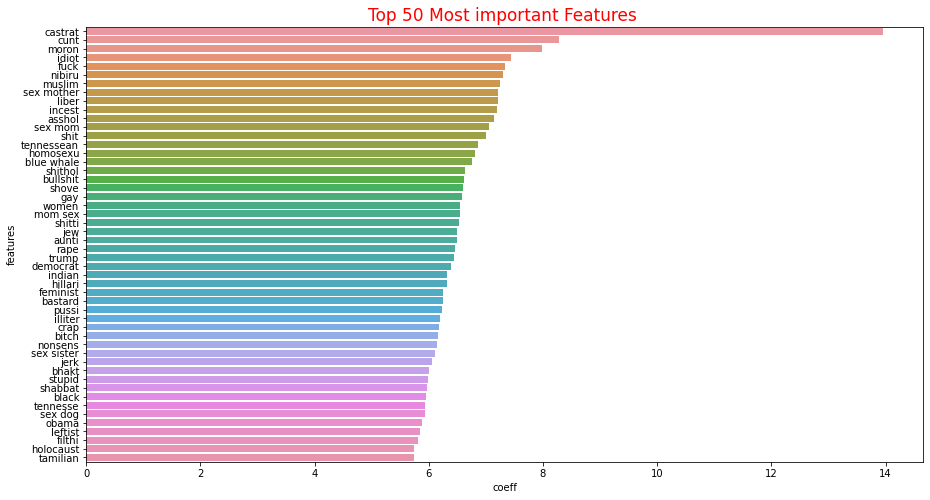

In [45]:
plt.figure(figsize=(15,8))
sbn.barplot(y=temp.features[:50],x=temp["coeff"][:50])
plt.title("Top 50 Most important Features ",size=17,color="red")

#### MultinomialNB

In [46]:
model_nb=MultinomialNB(alpha=0.001)
model_nb.fit(train_feat,y_train)
y_val_pre=model_nb.predict(val_feat)
y_train_pre=model_nb.predict(train_feat)

print("Accuracy")
print("train: ",accuracy_score(y_train,y_train_pre))
print("val :",accuracy_score(y_val,y_val_pre))
print("-"*50)
print("F1 score")
print("train: ",f1_score(y_train,y_train_pre))
print("val :",f1_score(y_val,y_val_pre))

Accuracy
train:  0.9469871193045821
val : 0.9461460426835104
--------------------------------------------------
F1 score
train:  0.4660658344980481
val : 0.45307518855454476


## Experiment 3: TFIDF + Feature Engineering

- we extracted feature from tfidf --> train_feat , val_feat
- we will concatenate tfidf features and derived features

In [47]:
t_feat=hstack([train_feat,normalize(x_train.iloc[:,1:].values)])
v_feat=hstack([val_feat,normalize(x_val.iloc[:,1:].values)])

In [48]:
model_lr=LogisticRegression(C=50,solver='sag')
model_lr.fit(t_feat,y_train)
y_val_pre=model_lr.predict(v_feat)
y_train_pre=model_lr.predict(t_feat)

print("Accuracy")
print("train: ",accuracy_score(y_train,y_train_pre))
print("val :",accuracy_score(y_val,y_val_pre))
print("-"*50)
print("F1 score")
print("train: ",f1_score(y_train,y_train_pre))
print("val :",f1_score(y_val,y_val_pre))

Accuracy
train:  0.9557602328267762
val : 0.9519532969662169
--------------------------------------------------
F1 score
train:  0.5731907742876665
val : 0.5365385325504967


In [49]:
model_nb=MultinomialNB(alpha=0.0001)
model_nb.fit(t_feat,y_train)
y_val_pre=model_nb.predict(v_feat)
y_train_pre=model_nb.predict(t_feat)

print("Accuracy")
print("train: ",accuracy_score(y_train,y_train_pre))
print("val :",accuracy_score(y_val,y_val_pre))
print("-"*50)
print("F1 score")
print("train: ",f1_score(y_train,y_train_pre))
print("val :",f1_score(y_val,y_val_pre))

Accuracy
train:  0.9471172756740617
val : 0.9461690113886496
--------------------------------------------------
F1 score
train:  0.4686878010788358
val : 0.4547921836228288
